In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

BASE_DIR    = Path('/Users/zaynguo/Documents/MSA/Hacklytics')
TOVER_PATH  = BASE_DIR / 'LIQ_TOVER_D_combined.csv'
RETURN_PATH = BASE_DIR / 'TRD_Dalyr_combined.csv'
OUT_PATH    = BASE_DIR / 'features_and_labels_h1.parquet'

START_DATE = pd.Timestamp('2016-05-01')
H = 1
K = 0.5

In [2]:
tover = pd.read_csv(TOVER_PATH, dtype={'Stkcd': str})
tover['Stkcd'] = tover['Stkcd'].str.zfill(6)
tover['Trddt'] = pd.to_datetime(tover['Trddt'], format='mixed', dayfirst=False)
tover = tover[tover['Trddt'] >= START_DATE].reset_index(drop=True)

print(tover.shape)
print(tover['Trddt'].min(), tover['Trddt'].max())
tover.head()

(10155367, 3)
2016-05-03 00:00:00 2025-12-31 00:00:00


,Stkcd,Trddt,ToverOs
0,000001,2016-05-03,0.414351
1,000001,2016-05-04,0.349402
2,000001,2016-05-05,0.202911
3,000001,2016-05-06,0.293581
4,000001,2016-05-09,0.348330


In [3]:
ret = pd.read_csv(RETURN_PATH, dtype={'Stkcd': str})
ret['Stkcd'] = ret['Stkcd'].str.zfill(6)
ret['Trddt'] = pd.to_datetime(ret['Trddt'], format='mixed', dayfirst=False)
ret = ret[ret['Trddt'] >= START_DATE].reset_index(drop=True)

# Log market cap (raw unit is thousands RMB)
ret['log_mcap'] = np.log(ret['Dsmvtll'])

print(ret.shape)
print(ret['Trddt'].min(), ret['Trddt'].max())
ret.head()

(10155367, 6)
2016-05-03 00:00:00 2025-12-31 00:00:00


,Stkcd,Trddt,Dsmvtll,Dretwd,LimitStatus,log_mcap
0,000001,2021-01-04,3.609501e+08,-0.038263,0.0,19.704250
1,000001,2021-01-05,3.526055e+08,-0.023118,0.0,19.680861
2,000001,2021-01-06,3.795798e+08,0.076500,0.0,19.754575
3,000001,2021-01-07,3.861778e+08,0.017382,0.0,19.771808
4,000001,2021-01-08,3.852075e+08,-0.002513,0.0,19.769293


In [4]:
df = pd.merge(
    ret[['Stkcd', 'Trddt', 'Dretwd', 'log_mcap', 'LimitStatus']],
    tover[['Stkcd', 'Trddt', 'ToverOs']],
    on=['Stkcd', 'Trddt'],
    how='inner'
)

print(df.shape)
print(df.isnull().sum())
df.head()

(10155367, 6)
Stkcd              0
Trddt              0
Dretwd             0
log_mcap           0
LimitStatus    26261
ToverOs         5682
dtype: int64


,Stkcd,Trddt,Dretwd,log_mcap,LimitStatus,ToverOs
0,000001,2021-01-04,-0.038263,19.704250,0.0,0.800905
1,000001,2021-01-05,-0.023118,19.680861,0.0,0.938563
2,000001,2021-01-06,0.076500,19.754575,0.0,0.997099
3,000001,2021-01-07,0.017382,19.771808,0.0,0.816348
4,000001,2021-01-08,-0.002513,19.769293,0.0,0.616041


In [5]:
# Fill missing LimitStatus with 0 (no limit)
df['LimitStatus'] = df['LimitStatus'].fillna(0).astype(int)

# Drop rows with missing ToverOs
df = df.dropna(subset=['ToverOs']).reset_index(drop=True)

print(df.shape)
print(df.isnull().sum())

(10149685, 6)
Stkcd          0
Trddt          0
Dretwd         0
log_mcap       0
LimitStatus    0
ToverOs        0
dtype: int64


In [6]:
# Equal-weighted market return per day (cross-sectional mean)
market_ret = df.groupby('Trddt')['Dretwd'].mean().rename('market_ret')
df = df.join(market_ret, on='Trddt')

# Demeaned return
df['demeaned_ret'] = df['Dretwd'] - df['market_ret']

print(df[['Dretwd', 'market_ret', 'demeaned_ret']].describe())
df.head()

             Dretwd    market_ret  demeaned_ret
count  1.014968e+07  1.014968e+07  1.014968e+07
mean   7.212520e-04  7.212520e-04  0.000000e+00
std    4.163681e-02  1.477805e-02  3.892600e-02
min   -9.644310e-01 -1.206523e-01 -9.468941e-01
25%   -1.386300e-02 -5.859831e-03 -1.245761e-02
50%    0.000000e+00  1.593517e-03 -2.432411e-03
75%    1.278100e-02  8.691279e-03  8.894161e-03
max    1.942581e+01  1.176447e-01  1.942356e+01


,Stkcd,Trddt,Dretwd,log_mcap,LimitStatus,ToverOs,market_ret,demeaned_ret
0,000001,2021-01-04,-0.038263,19.704250,0,0.800905,0.014719,-0.052982
1,000001,2021-01-05,-0.023118,19.680861,0,0.938563,-0.000634,-0.022484
2,000001,2021-01-06,0.076500,19.754575,0,0.997099,-0.011879,0.088379
3,000001,2021-01-07,0.017382,19.771808,0,0.816348,-0.023569,0.040951
4,000001,2021-01-08,-0.002513,19.769293,0,0.616041,-0.000921,-0.001592


In [7]:
# 20-day rolling mean of ToverOs per stock
df = df.sort_values(['Stkcd', 'Trddt']).reset_index(drop=True)
df['tover_rolling_mean'] = (
    df.groupby('Stkcd')['ToverOs']
    .transform(lambda x: x.rolling(20, min_periods=20).mean())
)

# Abnormal turnover
df['abnormal_tover'] = df['ToverOs'] / df['tover_rolling_mean'] - 1

# Drop rows where rolling mean couldn't be computed (first 20 days per stock)
df = df.dropna(subset=['abnormal_tover']).reset_index(drop=True)

print(df.shape)
print(df['abnormal_tover'].describe())

(10039589, 10)
count    1.003959e+07
mean     2.776973e-02
std      6.610449e-01
min     -9.999960e-01
25%     -3.565399e-01
50%     -1.362608e-01
75%      1.968623e-01
max      1.845652e+01
Name: abnormal_tover, dtype: float64


In [8]:
feature_cols = ['demeaned_ret', 'log_mcap', 'abnormal_tover', 'LimitStatus']

features = df[['Stkcd', 'Trddt'] + feature_cols].copy()

print(features.shape)
print(features.isnull().sum())
features.head()

(10039589, 6)
Stkcd             0
Trddt             0
demeaned_ret      0
log_mcap          0
abnormal_tover    0
LimitStatus       0
dtype: int64


,Stkcd,Trddt,demeaned_ret,log_mcap,abnormal_tover,LimitStatus
0,000001,2016-05-30,0.005013,18.806577,0.228172,0
1,000001,2016-05-31,-0.019079,18.832502,1.848767,0
2,000001,2016-06-01,-0.014938,18.825845,0.643427,0
3,000001,2016-06-02,-0.014510,18.823935,-0.140798,0
4,000001,2016-06-03,-0.001002,18.827752,0.229613,0


In [9]:
# Sort to ensure correct forward shift
df_sorted = features.sort_values(['Stkcd', 'Trddt']).copy()

# Forward 1-day demeaned return per stock
df_sorted['fwd_demeaned_ret_h1'] = (
    df_sorted.groupby('Stkcd')['demeaned_ret']
    .shift(-1)
)

# Drop last day per stock (no forward return available)
df_sorted = df_sorted.dropna(subset=['fwd_demeaned_ret_h1']).reset_index(drop=True)

print(df_sorted.shape)
print(df_sorted['fwd_demeaned_ret_h1'].describe())

(10033801, 7)
count    1.003380e+07
mean    -3.367543e-04
std      2.580878e-02
min     -9.468941e-01
25%     -1.243303e-02
50%     -2.442614e-03
75%      8.821396e-03
max      4.877907e+00
Name: fwd_demeaned_ret_h1, dtype: float64


In [12]:
# Compute expanding std: std of all fwd returns seen up to and including each date
df_sorted = df_sorted.sort_values(['Trddt', 'Stkcd']).reset_index(drop=True)

# One expanding std value per date
per_date_std = (
    df_sorted.set_index('Trddt')['fwd_demeaned_ret_h1']
    .expanding()
    .std()
    .groupby('Trddt')
    .last()
    .rename('expanding_std')
    .reset_index()
)

df_sorted = df_sorted.merge(per_date_std, on='Trddt', how='left')

# Labels
threshold = K * df_sorted['expanding_std']
df_sorted['label_h1'] = np.where(
    df_sorted['fwd_demeaned_ret_h1'] >  threshold, 2,
    np.where(df_sorted['fwd_demeaned_ret_h1'] < -threshold, 0, 1)
)

print(df_sorted['label_h1'].value_counts(normalize=True).sort_index())

label_h1
0    0.263353
1    0.528665
2    0.207982
Name: proportion, dtype: float64


In [13]:
output_cols = ['Stkcd', 'Trddt', 'demeaned_ret', 'log_mcap', 'abnormal_tover', 
               'LimitStatus', 'fwd_demeaned_ret_h1', 'expanding_std', 'label_h1']

df_sorted[output_cols].to_parquet(OUT_PATH, index=False)

print(f'Saved to {OUT_PATH}')
print(df_sorted[output_cols].shape)

Saved to /Users/zaynguo/Documents/MSA/Hacklytics/features_and_labels_h1.parquet
(10033801, 9)


In [15]:
SUPPLY_PATH = BASE_DIR / 'Supply_Chain_data.csv'

sc = pd.read_csv(SUPPLY_PATH, dtype={'Symbol': str, 'BusinessSymbol': str})
sc['Symbol'] = sc['Symbol'].str.zfill(6)
sc['BusinessSymbol'] = sc['BusinessSymbol'].str.zfill(6).where(sc['IsListed'] == 'Y', other=None)
sc['EndDate'] = pd.to_datetime(sc['EndDate'], format='mixed', dayfirst=False)

print(sc.shape)
print(sc['EndDate'].min(), sc['EndDate'].max())
print(sc['IsListed'].value_counts())
sc.head()

(63263, 14)
2001-12-31 00:00:00 2025-12-31 00:00:00
IsListed
N    55639
Y     7624
Name: count, dtype: int64


,Symbol,EndDate,StateTypeCode,BusinessRelations,Rank,BusinessInstitutionID,InstitutionName,IsListed,BusinessSymbol,GgrphclPrxmtySigns,SpatialDistance,Distance,IsSameProvince,IsSameCity
0,000002,2009-12-31,1,1,2,106555,上海陆家嘴(集团)有限公司,N,None,0,1198.781046,-7.089894,0,0
1,000002,2010-12-31,1,1,3,10242302,上海浦东工程建设管理有限公司,N,None,0,1205.749248,-7.095685,0,0
2,000004,2009-12-31,1,1,1,10542818,安徽华源医药股份有限公司,N,None,0,1188.827998,-7.081564,0,0
3,000004,2009-12-31,1,1,3,10515981,湖北思顿药业有限公司,N,None,0,894.865343,-6.797790,0,0
4,000004,2009-12-31,1,1,4,10519103,烟台众智医药有限公司,N,None,0,1802.434892,-7.497448,0,0


In [16]:
# Keep consolidated (1) preferentially, fall back to parent-only (2)
sc = sc.sort_values(['Symbol', 'EndDate', 'StateTypeCode'])
sc = sc.drop_duplicates(subset=['Symbol', 'EndDate', 'BusinessRelations', 'Rank'], keep='first')

print(sc.shape)

(59597, 14)


In [17]:
# Get unique trading dates from our features
trade_dates = df_sorted['Trddt'].unique()
trade_dates = pd.Series(sorted(trade_dates), name='Trddt')

# For each trading date, determine which snapshot year to use
# On/after May 1 of year Y -> use Dec 31 of year Y-1
def get_snapshot_date(trddt):
    if trddt.month >= 5:
        return pd.Timestamp(f'{trddt.year - 1}-12-31')
    else:
        return pd.Timestamp(f'{trddt.year - 2}-12-31')

trade_dates_df = pd.DataFrame({'Trddt': trade_dates})
trade_dates_df['snapshot_date'] = trade_dates_df['Trddt'].apply(get_snapshot_date)

print(trade_dates_df['snapshot_date'].value_counts().sort_index())

snapshot_date
2015-12-31    223
2016-12-31    244
2017-12-31    245
2018-12-31    244
2019-12-31    243
2020-12-31    241
2021-12-31    243
2022-12-31    242
2023-12-31    242
2024-12-31    164
Name: count, dtype: int64


In [18]:
needed_snapshots = trade_dates_df['snapshot_date'].unique()

sc_filtered = sc[sc['EndDate'].isin(needed_snapshots)].copy()

print(sc_filtered.shape)
print(sc_filtered['EndDate'].value_counts().sort_index())

(46143, 14)
EndDate
2015-12-31    4653
2016-12-31    4519
2017-12-31    4673
2018-12-31    4157
2019-12-31    4005
2020-12-31    3916
2021-12-31    4640
2022-12-31    5078
2023-12-31    5427
2024-12-31    5075
Name: count, dtype: int64


In [19]:
# Separate listed and unlisted partners
sc_listed = sc_filtered[sc_filtered['IsListed'] == 'Y'].copy()
sc_unlisted = sc_filtered[sc_filtered['IsListed'] == 'N'].copy()

print(f'Listed partner edges: {sc_listed.shape[0]}')
print(f'Unlisted partner edges: {sc_unlisted.shape[0]}')

# Build edge list for listed-to-listed pairs
# Each row: Symbol -> BusinessSymbol (or reverse), with edge features
edges_listed = sc_listed[['EndDate', 'Symbol', 'BusinessSymbol', 'BusinessRelations', 'Rank']].copy()
edges_listed = edges_listed.rename(columns={'Symbol': 'src', 'BusinessSymbol': 'dst'})

# Add reverse edges
edges_listed_rev = edges_listed.copy()
edges_listed_rev['src'] = edges_listed['dst']
edges_listed_rev['dst'] = edges_listed['src']

edges_listed_both = pd.concat([edges_listed, edges_listed_rev], ignore_index=True)

print(f'Total listed bidirectional edges: {edges_listed_both.shape[0]}')
edges_listed_both.head()

Listed partner edges: 4032
Unlisted partner edges: 42111
Total listed bidirectional edges: 8064


,EndDate,src,dst,BusinessRelations,Rank
0,2016-12-31,000004,301093,2,4
1,2019-12-31,000005,603588,1,2
2,2020-12-31,000005,603588,1,1
3,2021-12-31,000005,603588,1,5
4,2015-12-31,000006,002419,1,3


In [20]:
# For unlisted partners, use BusinessInstitutionID as node identifier
sc_unlisted = sc_unlisted.copy()
sc_unlisted['dst'] = 'UNLISTED_' + sc_unlisted['BusinessInstitutionID'].astype(str)

edges_unlisted = sc_unlisted[['EndDate', 'Symbol', 'dst', 'BusinessRelations', 'Rank']].copy()
edges_unlisted = edges_unlisted.rename(columns={'Symbol': 'src'})

# Add reverse edges
edges_unlisted_rev = edges_unlisted.copy()
edges_unlisted_rev['src'] = edges_unlisted['dst']
edges_unlisted_rev['dst'] = edges_unlisted['src']

edges_unlisted_both = pd.concat([edges_unlisted, edges_unlisted_rev], ignore_index=True)

# Combine all edges
edges_all = pd.concat([edges_listed_both, edges_unlisted_both], ignore_index=True)

print(f'Total edges across all snapshots: {edges_all.shape[0]}')
print(f'Unique snapshots: {edges_all["EndDate"].nunique()}')
edges_all.head(10)

Total edges across all snapshots: 92286
Unique snapshots: 10


,EndDate,src,dst,BusinessRelations,Rank
0,2016-12-31,000004,301093,2,4
1,2019-12-31,000005,603588,1,2
2,2020-12-31,000005,603588,1,1
3,2021-12-31,000005,603588,1,5
4,2015-12-31,000006,002419,1,3
5,2017-12-31,000007,000058,1,3
6,2018-12-31,000007,000058,1,5
7,2017-12-31,000010,300355,1,2
8,2021-12-31,000010,603843,1,1
9,2019-12-31,000011,002482,2,5


In [21]:
# Merge snapshot_date onto df_sorted
df_sorted = df_sorted.merge(trade_dates_df, on='Trddt', how='left')

print(df_sorted['snapshot_date'].value_counts().sort_index())
print(df_sorted.shape)

snapshot_date
2015-12-31     624438
2016-12-31     785342
2017-12-31     870604
2018-12-31     919749
2019-12-31     998150
2020-12-31    1114350
2021-12-31    1215454
2022-12-31    1292093
2023-12-31    1313755
2024-12-31     899866
Name: count, dtype: int64
(10033801, 11)


In [22]:
EDGES_PATH = BASE_DIR / 'edges_all.parquet'

# Save updated features with snapshot_date
df_sorted.to_parquet(OUT_PATH, index=False)

# Save edge list
edges_all.to_parquet(EDGES_PATH, index=False)

print(f'Features saved to {OUT_PATH}')
print(f'Edges saved to {EDGES_PATH}')
print(f'Features shape: {df_sorted.shape}')
print(f'Edges shape: {edges_all.shape}')


Features saved to /Users/zaynguo/Documents/MSA/Hacklytics/features_and_labels_h1.parquet
Edges saved to /Users/zaynguo/Documents/MSA/Hacklytics/edges_all.parquet
Features shape: (10033801, 11)
Edges shape: (92286, 5)


In [26]:
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
import torch
from tqdm import tqdm

device = torch.device('cpu')
print(f'Using device: {device}')

NODE2VEC_DIM = 64
NODE2VEC_WALK_LENGTH = 20
NODE2VEC_CONTEXT_SIZE = 10
NODE2VEC_WALKS_PER_NODE = 10
NODE2VEC_EPOCHS = 50
NODE2VEC_LR = 0.01
EMBED_PATH = BASE_DIR / 'node2vec_embeddings.parquet'

# Filter to snapshots from 2015 onward (already the case, but explicit is safer)
edges_all = edges_all[edges_all['EndDate'] >= pd.Timestamp('2015-12-31')].copy()

print(f'Snapshots: {sorted(edges_all["EndDate"].unique())}')
print(f'Total edges: {edges_all.shape[0]}')

Using device: cpu
Snapshots: [Timestamp('2015-12-31 00:00:00'), Timestamp('2016-12-31 00:00:00'), Timestamp('2017-12-31 00:00:00'), Timestamp('2018-12-31 00:00:00'), Timestamp('2019-12-31 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-12-31 00:00:00'), Timestamp('2023-12-31 00:00:00'), Timestamp('2024-12-31 00:00:00')]
Total edges: 92286


In [27]:
all_embeddings = []
snapshots = sorted(edges_all['EndDate'].unique())

for s_idx, snapshot in enumerate(snapshots):
    print(f'\n[{s_idx+1}/{len(snapshots)}] Snapshot: {snapshot.date()}')
    snap_edges = edges_all[edges_all['EndDate'] == snapshot].copy()
    
    # Build node index for this snapshot
    all_nodes = pd.unique(pd.concat([snap_edges['src'], snap_edges['dst']]))
    node2idx = {node: idx for idx, node in enumerate(all_nodes)}
    num_nodes = len(all_nodes)
    print(f'  Nodes: {num_nodes} | Edges: {len(snap_edges)}')
    
    # Build edge index tensor
    src_idx = snap_edges['src'].map(node2idx).values
    dst_idx = snap_edges['dst'].map(node2idx).values
    edge_index = torch.tensor(np.array([src_idx, dst_idx]), dtype=torch.long).to(device)
    
    # Train Node2Vec
    model = Node2Vec(
        edge_index,
        embedding_dim=NODE2VEC_DIM,
        walk_length=NODE2VEC_WALK_LENGTH,
        context_size=NODE2VEC_CONTEXT_SIZE,
        walks_per_node=NODE2VEC_WALKS_PER_NODE,
        num_nodes=num_nodes,
        sparse=True
    ).to(device)
    
    loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=NODE2VEC_LR)
    
    model.train()
    for epoch in range(NODE2VEC_EPOCHS):
        total_loss = 0
        batches = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batches += 1
        avg_loss = total_loss / batches
        print(f'  Epoch [{epoch+1:02d}/{NODE2VEC_EPOCHS}] Loss: {avg_loss:.4f}')
    
    # Extract embeddings
    model.eval()
    with torch.no_grad():
        emb = model.embedding.weight.cpu().numpy()
    
    emb_df = pd.DataFrame(emb, columns=[f'n2v_{i}' for i in range(NODE2VEC_DIM)])
    emb_df['node_id'] = all_nodes
    emb_df['snapshot_date'] = snapshot
    all_embeddings.append(emb_df)
    print(f'  Done. Embeddings shape: {emb_df.shape}')

embeddings_df = pd.concat(all_embeddings, ignore_index=True)
embeddings_df.to_parquet(EMBED_PATH, index=False)

print(f'\nAll snapshots done. Saved to {EMBED_PATH}')
print(f'Total embeddings shape: {embeddings_df.shape}')


[1/10] Snapshot: 2015-12-31
  Nodes: 4883 | Edges: 9306
  Epoch [01/50] Loss: 4.6648
  Epoch [02/50] Loss: 2.9861
  Epoch [03/50] Loss: 2.3219
  Epoch [04/50] Loss: 1.9151
  Epoch [05/50] Loss: 1.6182
  Epoch [06/50] Loss: 1.3993
  Epoch [07/50] Loss: 1.2403
  Epoch [08/50] Loss: 1.1250
  Epoch [09/50] Loss: 1.0418
  Epoch [10/50] Loss: 0.9802
  Epoch [11/50] Loss: 0.9363
  Epoch [12/50] Loss: 0.9028
  Epoch [13/50] Loss: 0.8755
  Epoch [14/50] Loss: 0.8555
  Epoch [15/50] Loss: 0.8393
  Epoch [16/50] Loss: 0.8260
  Epoch [17/50] Loss: 0.8151
  Epoch [18/50] Loss: 0.8056
  Epoch [19/50] Loss: 0.7980
  Epoch [20/50] Loss: 0.7907
  Epoch [21/50] Loss: 0.7853
  Epoch [22/50] Loss: 0.7805
  Epoch [23/50] Loss: 0.7761
  Epoch [24/50] Loss: 0.7722
  Epoch [25/50] Loss: 0.7692
  Epoch [26/50] Loss: 0.7657
  Epoch [27/50] Loss: 0.7634
  Epoch [28/50] Loss: 0.7608
  Epoch [29/50] Loss: 0.7582
  Epoch [30/50] Loss: 0.7564
  Epoch [31/50] Loss: 0.7549
  Epoch [32/50] Loss: 0.7531
  Epoch [33/50]

In [28]:
# Load embeddings
embeddings_df = pd.read_parquet(EMBED_PATH)

# Merge Node2Vec embeddings into features for listed firms only
# Join on Stkcd = node_id and snapshot_date
df_final = df_sorted.merge(
    embeddings_df,
    left_on=['Stkcd', 'snapshot_date'],
    right_on=['node_id', 'snapshot_date'],
    how='left'
)

# Drop redundant node_id column
df_final = df_final.drop(columns=['node_id'])

print(df_final.shape)
print(f'Rows with Node2Vec embeddings: {df_final["n2v_0"].notna().sum()}')
print(f'Rows without (unlisted or not in graph): {df_final["n2v_0"].isna().sum()}')
df_final.head()

(10033801, 75)
Rows with Node2Vec embeddings: 2072962
Rows without (unlisted or not in graph): 7960839


,Stkcd,Trddt,demeaned_ret,log_mcap,abnormal_tover,LimitStatus,fwd_demeaned_ret_h1,date_rank,expanding_std,label_h1,...,n2v_54,n2v_55,n2v_56,n2v_57,n2v_58,n2v_59,n2v_60,n2v_61,n2v_62,n2v_63
0,000001,2016-05-30,0.005013,18.806577,0.228172,0,-0.019079,0,0.017945,0,...,0.146906,0.098366,-0.199566,-0.034801,0.215103,-0.219285,-0.160972,0.222989,0.043973,0.399034
1,000005,2016-05-30,-0.007726,15.777486,-0.574230,0,-0.011118,0,0.017945,0,...,-0.114958,-0.192342,-0.379429,-0.135221,0.122469,-0.033189,-1.160386,-0.078194,0.526843,-0.180926
2,000006,2016-05-30,-0.023209,16.081324,-0.006403,0,-0.011731,0,0.017945,0,...,0.615389,-0.245552,0.178558,0.310137,-0.155232,-0.282086,-0.552939,0.504246,0.101517,0.309409
3,000008,2016-05-30,-0.005593,17.255598,-0.381882,0,-0.023240,0,0.017945,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000009,2016-05-30,-0.008048,16.786911,-0.428583,0,0.000333,0,0.017945,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Fill missing Node2Vec embeddings with zeros
n2v_cols = [f'n2v_{i}' for i in range(NODE2VEC_DIM)]
df_final[n2v_cols] = df_final[n2v_cols].fillna(0.0)

print(f'Remaining nulls in n2v cols: {df_final[n2v_cols].isna().sum().sum()}')
print(df_final.shape)

Remaining nulls in n2v cols: 0
(10033801, 75)


In [30]:
FINAL_PATH = BASE_DIR / 'features_labels_embeddings_h1.parquet'
df_final.to_parquet(FINAL_PATH, index=False)

print(f'Saved to {FINAL_PATH}')
print(df_final.shape)

Saved to /Users/zaynguo/Documents/MSA/Hacklytics/features_labels_embeddings_h1.parquet
(10033801, 75)


In [31]:
import torch
from torch.utils.data import Dataset, DataLoader

T = 20  # rolling window size

# Sort and group by stock
df_final = df_final.sort_values(['Stkcd', 'Trddt']).reset_index(drop=True)

# Build index of valid windows
# For each stock, find all positions where we have T consecutive trading days
print('Building window index...')
window_index = []  # list of (start_idx, end_idx) into df_final

stock_groups = df_final.groupby('Stkcd')
total_stocks = len(stock_groups)

for i, (stkcd, group) in enumerate(stock_groups):
    if i % 500 == 0:
        print(f'  Processing stock {i+1}/{total_stocks}...', end='\r')
    
    idxs = group.index.values
    if len(idxs) < T:
        continue
    
    for j in range(len(idxs) - T):
        # Window: idxs[j] to idxs[j+T-1], label on idxs[j+T-1]
        window_index.append((idxs[j], idxs[j + T - 1]))

print(f'\nDone. Total windows: {len(window_index):,}')

Building window index...
  Processing stock 5501/5788...
Done. Total windows: 9,918,153


In [32]:
FEATURE_COLS = ['demeaned_ret', 'log_mcap', 'abnormal_tover', 'LimitStatus'] + n2v_cols

class StockWindowDataset(Dataset):
    def __init__(self, df, window_index, feature_cols, label_col='label_h1'):
        self.df = df
        self.window_index = window_index
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.data_values = df[feature_cols].values.astype('float32')
        self.label_values = df[label_col].values.astype('int64')
    
    def __len__(self):
        return len(self.window_index)
    
    def __getitem__(self, idx):
        start, end = self.window_index[idx]
        x = self.data_values[start:end + 1]  # shape: (T, num_features)
        y = self.label_values[end]            # label on last day of window
        return torch.tensor(x), torch.tensor(y)

# Quick sanity check
dataset = StockWindowDataset(df_final, window_index, FEATURE_COLS)
x_sample, y_sample = dataset[0]

print(f'Dataset size: {len(dataset):,}')
print(f'Sample x shape: {x_sample.shape}')  # expected: (20, 68)
print(f'Sample y: {y_sample}')
print(f'Feature dims: {len(FEATURE_COLS)} (4 market + 64 n2v)')

Dataset size: 9,918,153
Sample x shape: torch.Size([20, 68])
Sample y: 1
Feature dims: 68 (4 market + 64 n2v)


In [33]:
# Train: 2016-2021 | Val: 2022-2023 | Test: 2024-2025
train_end = pd.Timestamp('2021-12-31')
val_end   = pd.Timestamp('2023-12-31')

# Get the date of the last day in each window (end index)
print('Splitting windows by date...')
end_dates = df_final['Trddt'].values

train_idx = [(s, e) for s, e in window_index if end_dates[e] <= train_end]
val_idx   = [(s, e) for s, e in window_index if train_end < end_dates[e] <= val_end]
test_idx  = [(s, e) for s, e in window_index if end_dates[e] > val_end]

print(f'Train windows: {len(train_idx):,}')
print(f'Val windows:   {len(val_idx):,}')
print(f'Test windows:  {len(test_idx):,}')

Splitting windows by date...
Train windows: 4,853,513
Val windows:   2,438,412
Test windows:  2,626,228


In [34]:
train_dataset = StockWindowDataset(df_final, train_idx, FEATURE_COLS)
val_dataset   = StockWindowDataset(df_final, val_idx,   FEATURE_COLS)
test_dataset  = StockWindowDataset(df_final, test_idx,  FEATURE_COLS)

# DataLoaders
BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train batches: {len(train_loader):,}')
print(f'Val batches:   {len(val_loader):,}')
print(f'Test batches:  {len(test_loader):,}')

Train batches: 4,740
Val batches:   2,382
Test batches:  2,565


In [35]:
# Reset device to MPS for model training
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

import torch.nn as nn

class HTGNN(nn.Module):
    def __init__(self, input_dim=68, hidden_dim=128, num_layers=2, num_classes=3, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # x: (batch, T, input_dim)
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]  # take last timestep
        return self.classifier(last_hidden)

model = HTGNN().to(device)
print(f'Device: {device}')
print(model)
print(f'Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Using device: mps
Device: mps
HTGNN(
  (lstm): LSTM(68, 128, num_layers=2, batch_first=True, dropout=0.3)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)
Trainable params: 241,923


In [37]:
from sklearn.metrics import f1_score
import time

# Class weights to handle imbalance (0: 26.3%, 1: 52.9%, 2: 20.8%)
class_counts = df_final['label_h1'].value_counts().sort_index().values
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)
class_weights = class_weights / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

EPOCHS = 10
best_val_f1 = 0
MODEL_PATH = BASE_DIR / 'htgnn_best.pt'

for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    model.train()
    train_loss, correct, total = 0, 0, 0
    start = time.time()
    
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        
        if (batch_idx + 1) % 500 == 0:
            print(f'  Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx+1}/{len(train_loader)}] '
                  f'Loss: {train_loss/(batch_idx+1):.4f} '
                  f'Acc: {correct/total:.4f}')
    
    train_acc = correct / total
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Validate ---
    model.eval()
    val_loss, all_preds, all_labels = 0, [], []
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            all_preds.extend(out.argmax(dim=1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    elapsed = time.time() - start
    print(f'\nEpoch [{epoch}/{EPOCHS}] | Time: {elapsed:.1f}s')
    print(f'  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val Macro F1: {val_f1:.4f}')
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print(f'  *** New best model saved (Val F1: {val_f1:.4f}) ***')
    
    scheduler.step(avg_val_loss)
    print()

print(f'Training done. Best Val Macro F1: {best_val_f1:.4f}')

  Epoch [1/10] Batch [500/4740] Loss: 1.0848 Acc: 0.4290
  Epoch [1/10] Batch [1000/4740] Loss: 1.0776 Acc: 0.4480
  Epoch [1/10] Batch [1500/4740] Loss: 1.0694 Acc: 0.4577
  Epoch [1/10] Batch [2000/4740] Loss: 1.0646 Acc: 0.4642
  Epoch [1/10] Batch [2500/4740] Loss: 1.0611 Acc: 0.4685
  Epoch [1/10] Batch [3000/4740] Loss: 1.0589 Acc: 0.4711
  Epoch [1/10] Batch [3500/4740] Loss: 1.0572 Acc: 0.4731
  Epoch [1/10] Batch [4000/4740] Loss: 1.0558 Acc: 0.4750
  Epoch [1/10] Batch [4500/4740] Loss: 1.0547 Acc: 0.4761

Epoch [1/10] | Time: 479.0s
  Train Loss: 1.0542 | Train Acc: 0.4766
  Val Loss:   1.0413 | Val Acc:   0.4797 | Val Macro F1: 0.4309
  *** New best model saved (Val F1: 0.4309) ***

  Epoch [2/10] Batch [500/4740] Loss: 1.0450 Acc: 0.4853
  Epoch [2/10] Batch [1000/4740] Loss: 1.0448 Acc: 0.4859
  Epoch [2/10] Batch [1500/4740] Loss: 1.0447 Acc: 0.4860
  Epoch [2/10] Batch [2000/4740] Loss: 1.0447 Acc: 0.4862
  Epoch [2/10] Batch [2500/4740] Loss: 1.0446 Acc: 0.4868
  Epoch

  Batch [2500/2565] done...
Test Results:
              precision    recall  f1-score   support

Underperform       0.37      0.53      0.43    677123
     Neutral       0.69      0.61      0.64   1408847
  Outperform       0.27      0.21      0.24    540258

    accuracy                           0.50   2626228
   macro avg       0.44      0.45      0.44   2626228
weighted avg       0.52      0.50      0.50   2626228



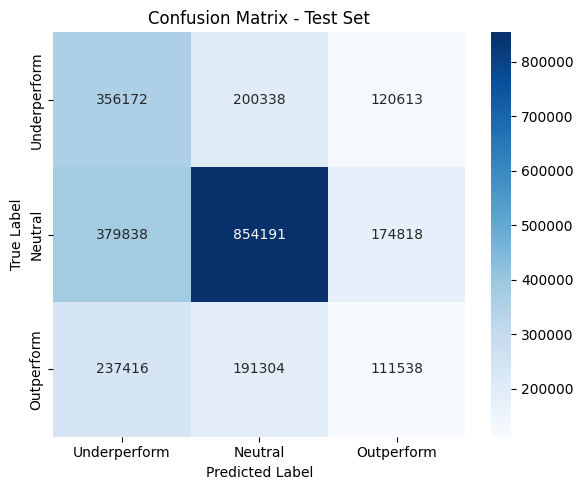

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# Run on test set
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        all_preds.extend(out.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        
        if (batch_idx + 1) % 500 == 0:
            print(f'  Batch [{batch_idx+1}/{len(test_loader)}] done...', end='\r')

print('\nTest Results:')
print(classification_report(all_labels, all_preds, 
      target_names=['Underperform', 'Neutral', 'Outperform']))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Underperform', 'Neutral', 'Outperform'],
            yticklabels=['Underperform', 'Neutral', 'Outperform'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [40]:
# Vectorized CAR computation
print('Building CAR dataset...')

# Build test_meta_df
test_ends = [end for _, end in test_idx]
test_meta_df = df_final.iloc[test_ends][['Stkcd', 'Trddt', 'label_h1', 'fwd_demeaned_ret_h1']].copy()
test_meta_df['pred'] = all_preds
test_meta_df = test_meta_df.reset_index(drop=True)

print(f'Test meta shape: {test_meta_df.shape}')

# Get all demeaned returns for test period stocks
N = 10
test_start_date = test_meta_df['Trddt'].min()
test_stocks = test_meta_df['Stkcd'].unique()

ret_lookup = df_final[
    (df_final['Stkcd'].isin(test_stocks)) &
    (df_final['Trddt'] >= test_start_date)
][['Stkcd', 'Trddt', 'demeaned_ret']].copy()

ret_lookup = ret_lookup.sort_values(['Stkcd', 'Trddt']).reset_index(drop=True)

# Assign day rank per stock
ret_lookup['day_rank'] = ret_lookup.groupby('Stkcd').cumcount()

# Assign day rank to test_meta_df predictions
rank_lookup = ret_lookup[['Stkcd', 'Trddt', 'day_rank']].rename(columns={'day_rank': 'pred_rank'})
test_meta_df = test_meta_df.merge(rank_lookup, on=['Stkcd', 'Trddt'], how='left')

# For each t in 1..N, shift by t days and merge
car_frames = []
for t in range(1, N + 1):
    shifted = ret_lookup[['Stkcd', 'day_rank', 'demeaned_ret']].copy()
    shifted['pred_rank'] = shifted['day_rank'] - t
    merged = test_meta_df[['Stkcd', 'pred', 'pred_rank']].merge(
        shifted[['Stkcd', 'pred_rank', 'demeaned_ret']],
        on=['Stkcd', 'pred_rank'],
        how='inner'
    )
    merged['t'] = t
    car_frames.append(merged)

car_df = pd.concat(car_frames, ignore_index=True)

print(f'CAR rows: {car_df.shape}')
car_df.head()

Building CAR dataset...
Test meta shape: (2626228, 5)
CAR rows: (26010034, 5)


,Stkcd,pred,pred_rank,demeaned_ret,t
0,000001,1,0,0.002854,1
1,000001,1,1,-0.006790,1
2,000001,1,2,0.035468,1
3,000001,1,3,0.007647,1
4,000001,1,4,-0.000389,1


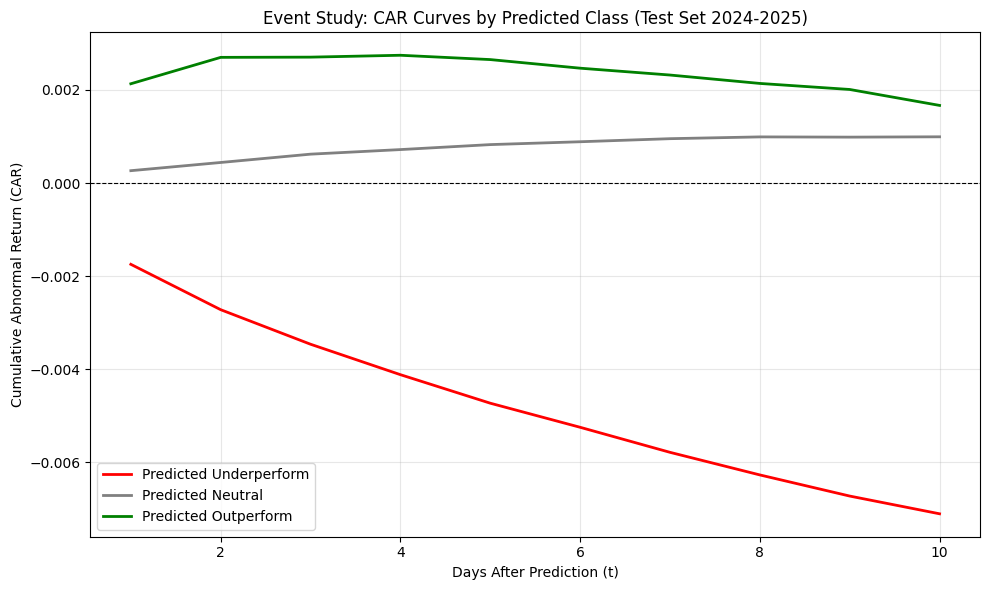


CAR at t=10:
  Predicted Underperform: -0.007103
  Predicted Neutral: 0.000994
  Predicted Outperform: 0.001669


In [41]:
# Compute cumulative abnormal returns per prediction class
car_summary = car_df.groupby(['pred', 't'])['demeaned_ret'].mean().reset_index()
car_summary['CAR'] = car_summary.groupby('pred')['demeaned_ret'].cumsum()

label_map = {0: 'Predicted Underperform', 1: 'Predicted Neutral', 2: 'Predicted Outperform'}
colors = {0: 'red', 1: 'gray', 2: 'green'}

plt.figure(figsize=(10, 6))
for pred_class in [0, 1, 2]:
    subset = car_summary[car_summary['pred'] == pred_class]
    plt.plot(subset['t'], subset['CAR'], 
             label=label_map[pred_class], 
             color=colors[pred_class],
             linewidth=2)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Days After Prediction (t)')
plt.ylabel('Cumulative Abnormal Return (CAR)')
plt.title('Event Study: CAR Curves by Predicted Class (Test Set 2024-2025)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary at t=10
print('\nCAR at t=10:')
for pred_class in [0, 1, 2]:
    car_t10 = car_summary[(car_summary['pred'] == pred_class) & (car_summary['t'] == 10)]['CAR'].values[0]
    print(f'  {label_map[pred_class]}: {car_t10:.6f}')